In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Ensure reproducibility
torch.manual_seed(0)
random.seed(0)

In [25]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [26]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\momos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\momos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\momos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [28]:
def preprocess_text(text, remove_stopwords):
    """Tokenize, optionally remove stop words, lemmatize, and clean text."""
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha()]
    if remove_stopwords:
        words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

In [29]:
def load_and_preprocess_text(file_path, remove_stopwords, sampling_ratio=0.5):
    """Load text from a file, preprocess, and sample it."""
    with open('HP1.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    words = preprocess_text(text, remove_stopwords=remove_stopwords)
    return words[:int(len(words) * sampling_ratio)]

In [30]:
def create_vocabulary(words):
    """Create vocabulary and mapping dictionaries."""
    vocab = sorted(set(words))
    word_to_index = {word: i for i, word in enumerate(vocab)}
    index_to_word = {i: word for i, word in enumerate(vocab)}
    return vocab, word_to_index, index_to_word

In [31]:
def one_hot_vector(word_index, vocab_size):
    """Generate a one-hot encoded vector."""
    vector = torch.zeros(vocab_size, device=device)
    vector[word_index] = 1
    return vector

In [32]:
def generate_training_data(words, word_to_index, window_size=2):
    """Generate input-output pairs for training."""
    vocab_size = len(word_to_index)
    training_data = []
    for i, word in enumerate(words):
        if word not in word_to_index:
            continue
        input_word = word_to_index[word]
        input_vector = one_hot_vector(input_word, vocab_size)
        for j in range(-window_size, window_size + 1):
            if j != 0 and 0 <= i + j < len(words):
                if words[i + j] not in word_to_index:
                    continue
                output_word = word_to_index[words[i + j]]
                output_vector = one_hot_vector(output_word, vocab_size)
                training_data.append((input_vector, output_vector))
    return training_data

In [33]:
class Word2VecDataset(Dataset):
    """Custom dataset for Word2Vec training data."""

    def __init__(self, training_data):
        self.training_data = training_data

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        return self.training_data[idx]

In [34]:
class Word2Vec(nn.Module):
    """Simple Word2Vec model with one hidden layer."""

    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Linear(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_vector):
        embed = self.embeddings(input_vector)
        output = self.linear(embed)
        return output

    def get_embedding(self, input_vector):
        with torch.no_grad():
            embed = self.embeddings(input_vector)
        return embed

In [35]:
def train_word2vec_model(train_loader, model, epochs=100, lr=0.01):
    """Train the Word2Vec model."""
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for input_vector, output_vector in train_loader:
            optimizer.zero_grad()
            output = model(input_vector)
            loss = loss_function(output, output_vector)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(
                f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

In [36]:
def save_word2vec_model(model, file_path):
    """Save the trained Word2Vec model."""
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

In [37]:
def load_word2vec_model(file_path, vocab_size, embedding_dim):
    """Load a saved Word2Vec model."""
    model = Word2Vec(vocab_size, embedding_dim)
    model.load_state_dict(torch.load(file_path))
    model.to(device)
    model.eval()  # Set model to evaluation mode
    print(f"Model loaded from {file_path}")
    return model

In [38]:
def get_word_embedding(word, model, word_to_index):
    """Retrieve the embedding for a given word."""
    input_vector = one_hot_vector(
        word_to_index[word], len(word_to_index)).unsqueeze(0)
    embedding = model.get_embedding(input_vector).squeeze(0)
    return embedding

In [39]:
def infer_embedding_from_one_hot(one_hot_vector, model):
    """
    Given a 1-hot vector, return the corresponding word embedding using the trained model.

    Args:
        one_hot_vector (torch.Tensor): A 1-hot encoded vector of size [vocab_size].
        model (Word2Vec): The trained Word2Vec model.

    Returns:
        torch.Tensor: The corresponding embedding vector.
    """
    one_hot_vector = one_hot_vector.to(
        device)  # Ensure the vector is on the correct device
    embedding = model.get_embedding(one_hot_vector.unsqueeze(0)).squeeze(0)
    return embedding

In [40]:
def sentence_to_vec(sentence, model, word_to_index):
    """Convert a sentence to a vector by averaging word embeddings."""
    words = word_tokenize(sentence.lower())
    word_vectors = [get_word_embedding(word, model, word_to_index).cpu().numpy()
                    for word in words if word in word_to_index]

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.embeddings.out_features)

In [41]:
def create_synthetic_dataset():
    """Create a synthetic dataset for text classification into 'wizard' and 'magic' categories."""
    return [
        # Wizard examples
        ("harry potter is a young wizard", "wizard"),
        ("dumbledore is a powerful and wise wizard", "wizard"),
        ("professor mcgonagall is a witch who can transform into a cat", "wizard"),
        ("voldemort is a dark wizard feared by many", "wizard"),
        ("hermione granger is an exceptionally talented witch", "wizard"),
        ("ron weasley is harry's best friend and a brave wizard", "wizard"),
        ("sirius black is harry's godfather and a skilled wizard", "wizard"),
        ("draco malfoy is a slytherin student and harry's rival", "wizard"),
        ("remus lupin is a werewolf and a former defense against the dark arts professor", "wizard"),
        ("severus snape is a potions master with a mysterious past", "wizard"),
        ("professor flitwick teaches charms at hogwarts", "wizard"),
        ("bellatrix lestrange is a devoted follower of voldemort", "wizard"),
        ("gilderoy lockhart is a flamboyant wizard known for his books", "wizard"),
        ("alastor 'mad-eye' moody is a famous auror", "wizard"),
        ("minerva mcgonagall is the head of gryffindor house", "wizard"),
        ("peter pettigrew betrayed harry's parents to voldemort", "wizard"),
        ("lucius malfoy is draco's father and a follower of voldemort", "wizard"),
        ("arthur weasley works for the ministry of magic", "wizard"),
        ("narcissa malfoy is draco's mother and loyal to her family", "wizard"),
        ("hagrid is the keeper of keys and grounds at hogwarts", "wizard"),
        ("horace slughorn is a professor who loves collecting famous students", "wizard"),
        ("albus dumbledore is the headmaster of hogwarts", "wizard"),
        ("rubeus hagrid is half-giant and a loyal friend to harry", "wizard"),
        ("voldemort once attended hogwarts as tom riddle", "wizard"),
        ("gellert grindelwald was a dark wizard before voldemort's rise", "wizard"),

        # Magic examples
        ("the invisibility cloak is a rare magical artifact", "magic"),
        ("the philosopher's stone grants immortality", "magic"),
        ("the elder wand is the most powerful wand in existence", "magic"),
        ("fawkes, dumbledore's phoenix, has healing tears", "magic"),
        ("the marauder's map shows everyone's location at hogwarts", "magic"),
        ("polyjuice potion allows the drinker to assume another's form", "magic"),
        ("the patronus charm wards off dementors", "magic"),
        ("the resurrection stone can bring back the dead temporarily", "magic"),
        ("the sorting hat determines students' houses at hogwarts", "magic"),
        ("the put-outer can extinguish lights from a distance", "magic"),
        ("quidditch is a popular magical sport", "magic"),
        ("the chamber of secrets was created by salazar slytherin", "magic"),
        ("the time turner allows its user to travel through time", "magic"),
        ("the triwizard tournament is a dangerous magical competition", "magic"),
        ("dumbledore used a deluminator to turn off street lamps", "magic"),
        ("the sword of gryffindor appears to those who need it most", "magic"),
        ("the prophecy foretold harry's battle with voldemort", "magic"),
        ("voldemort created horcruxes to achieve immortality", "magic"),
        ("the room of requirement appears when someone is in need", "magic"),
        ("the basilisk is a giant serpent that petrifies students", "magic"),
        ("the mirror of erised shows the deepest desires of one's heart", "magic"),
        ("the killing curse is one of the unforgivable curses", "magic"),
        ("the goblet of fire selects champions for the triwizard tournament", "magic"),
        ("the whomping willow is a magical tree that attacks anyone who approaches", "magic"),
        ("the firebolt is the fastest broomstick in the world", "magic"),
    ]


In [42]:
def prepare_features_and_labels(data, model, word_to_index, label_to_index):
    """Prepare feature vectors and labels for classification."""
    X = np.array([sentence_to_vec(sentence, model, word_to_index)
                 for sentence, _ in data])
    y = np.array([label_to_index[label] for _, label in data])
    return X, y

In [43]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, index_to_label):
    """Train a classifier and evaluate its performance."""
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=index_to_label.values(),
                yticklabels=index_to_label.values())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [44]:
# Load and preprocess text data
sampled_words = load_and_preprocess_text('HP1.txt', remove_stopwords=True, sampling_ratio=0.0125)
print(f"Number of words in text: {len(sampled_words)}")
print(f"Sampled words: {sampled_words[:10]}")

Number of words in text: 495
Sampled words: ['dursley', 'number', 'four', 'privet', 'drive', 'proud', 'say', 'perfectly', 'normal', 'thank']


In [45]:
# Create vocabulary and mappings
vocab, word_to_index, index_to_word = create_vocabulary(sampled_words)
print(f"Vocabulary size: {len(vocab)}")
print(f"Sampled vocabulary: {vocab[:10]}")

Vocabulary size: 324
Sampled vocabulary: ['across', 'almost', 'also', 'although', 'always', 'amount', 'angrily', 'another', 'anyone', 'anything']


In [46]:
# Generate training data
training_data = generate_training_data(sampled_words, word_to_index)
print(f"Number of training samples: {len(training_data)}")

Number of training samples: 1974


In [47]:
# Create DataLoader for batch processing
train_loader = DataLoader(Word2VecDataset(training_data), batch_size=64, shuffle=True)

In [48]:
# Initialize and train Word2Vec model
embedding_dim = 100
model = Word2Vec(len(vocab), embedding_dim).to(device)
train_word2vec_model(train_loader, model, epochs=100, lr=0.01)

Epoch 10/100, Loss: 0.006971724902189547
Epoch 20/100, Loss: 0.006762528161127721
Epoch 30/100, Loss: 0.006569579468979951
Epoch 40/100, Loss: 0.006389864209678865
Epoch 50/100, Loss: 0.006223133930395688
Epoch 60/100, Loss: 0.006067483745996029
Epoch 70/100, Loss: 0.00592278967040681
Epoch 80/100, Loss: 0.005787897734872757
Epoch 90/100, Loss: 0.005661305821230335
Epoch 100/100, Loss: 0.0055423639264077906


In [49]:
# Save the trained model
save_word2vec_model(model, "word2vec_model.pth")

Model saved to word2vec_model.pth


In [50]:
# Example: Inference from a 1-hot vector
word = "wizard"
if word in word_to_index:
    one_hot_vec = one_hot_vector(word_to_index[word], len(vocab))
    embedding = infer_embedding_from_one_hot(one_hot_vec, model)
    print(f"Embedding for '{word}': {embedding.cpu().numpy()}")
else:
    print(f"Word '{word}' not found in vocabulary.")

Word 'wizard' not found in vocabulary.


In [51]:
# Load the saved model (optional, just to demonstrate loading)
loaded_model = load_word2vec_model("word2vec_model.pth", len(vocab), embedding_dim)

Model loaded from word2vec_model.pth


In [52]:
# Create and process synthetic dataset for classification
data = create_synthetic_dataset()
label_to_index = {"wizard": 0, "magic": 1}
index_to_label = {v: k for k, v in label_to_index.items()}
X, y = prepare_features_and_labels(data, loaded_model, word_to_index, label_to_index)

Test Accuracy: 0.0667


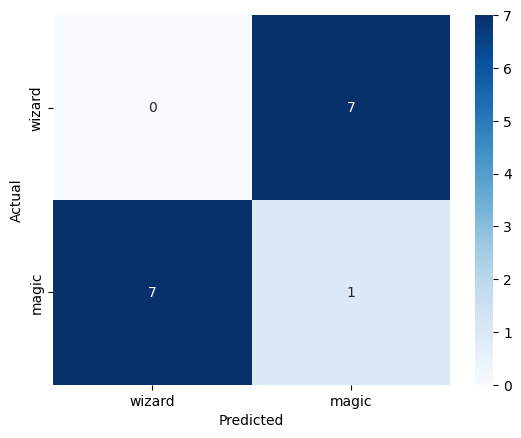

In [53]:
# Split data and evaluate classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train_and_evaluate_classifier(X_train, y_train, X_test, y_test, index_to_label)